## ModelOptions vs SolverOptions


The distinction between **`ModelOptions`** and **`SolverOptions`** is essential when working with `optiwindnet`.
This notebook presents a clear and structured explanation of their roles and differences:

- **`ModelOptions`** define *how the optimization problem is formulated*, including structural assumptions and model features such as topology type, feeder constraints, and balancing requirements.
- **`SolverOptions`** configure *how the underlying solver behaves during execution*, controlling aspects like time limits, optimality gaps, and solver verbosity.

Understanding this separation helps ensure that models are both correctly formulated and efficiently solved.

---

### 🔧 What is `ModelOptions`?

`ModelOptions` is a configuration object or dictionary that **controls how the mathematical model is built and behaves**, regardless of the solver used. These options are typically **high-level**, problem-specific settings that:

* Affect the **structure** of the model (e.g., topology type)
* Enable or disable **features** (e.g., balancing constraints)
* Influence **heuristic/metaheuristic behavior** if used

#### ✅ Examples of `ModelOptions`:

| Parameter      | Description                                                                 |
| -------------- | --------------------------------------------------------------------------- |
| `topology`     | Controls whether the solution allows "radial" or "branched" subtrees        |
| `feeder_route` | Determines if feeder paths must be "straight" or may be "segmented"         |
| `feeder_limit` | Specifies limits on the number of feeders used in the solution              |
| `balanced`     | Whether subtree loads must be balanced                                      |
| `max_feeders`  | Required when `feeder_limit="specified"` to indicate the max number allowed |

These options **change the formulation** of the problem before it is handed to the solver.

---

### 🧮 What is `SolverOptions`?

`SolverOptions` refers to **solver-specific configuration parameters** that affect **how the solver works internally** (once the model is already built).

These settings are typically passed directly to a solver like CPLEX, Gurobi, CBC, etc., and influence:

* **Search strategy**
* **Runtime limits**
* **Optimality tolerances**
* **Logging and precision settings**

#### ✅ Common `SolverOptions` for MILP:

| Parameter      | Description                                           |
| -------------- | ----------------------------------------------------- |
| `time_limit`   | Maximum allowed solve time (in seconds)               |
| `gap`          | Optimality tolerance (e.g., 0.01 for 1% gap)          |
| `mip_emphasis` | Prioritize bound quality, feasibility, or integrality |
| `threads`      | Number of threads to use                              |
| `verbose`      | Control solver output/logging                         |

---

### 🆚 Key Differences

| Feature       | `ModelOptions`                                 | `SolverOptions`                           |
| ------------- | ---------------------------------------------- | ----------------------------------------- |
| Scope         | Problem formulation level                      | Solver execution level                    |
| Affects       | Model structure and constraints                | Search process and performance            |
| Applicable to | All methods (heuristics, metaheuristics, MILP) | Only solver-based methods (e.g., MILP)    |
| Examples      | `topology`, `feeder_limit`, `balanced`         | `time_limit`, `gap`, `threads`            |
| Impact        | Determines **what** is solved                  | Determines **how** it's solved            |
| Defined by    | The modeling framework                         | The specific solver (e.g., CPLEX, Gurobi) |

---

### 🎯 Summary

* **Use `ModelOptions`** to specify **what kind of solution** you want (structure, constraints, flexibility).
* **Use `SolverOptions`** to control **how long and how hard** the solver should try to find that solution.

### ModelOptions Capability Summary

| Method           | Topology                                                              | Feeder Route                                                      | Feeder Limit                                                    |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------|------------------------------------------------------------------|
| **Heuristic**      | May produce *branched* or *radial* topologies; not user-controllable | May yield *straight* or *segmented* routes; no control available   | Not controllable                                                 |
| **Metaheuristic**  | Always produces *radial* topology                                     | May yield *straight* or *segmented* routes; not user-controllable | Controllable via `feeder_limit` parameter in `ModelOptions`              |
| **MILP**           | Fully controllable via `topology` parameter in `ModelOptions`         | Fully controllable via `feeder_route` parameter in `ModelOptions`                   | Fully controllable via `feeder_limit` parameter in `ModelOptions`   |


In [1]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MetaHeuristic, MILP, ModelOptions, load_repository

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

In [3]:
ModelOptions.help()

topology in {"radial", "branched", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3", "unlimited"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



### Initialize Moray East

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [4]:
locations = load_repository()
#wfn = WindFarmNetwork(L=locations.morayeast, cables=7)
wfn = WindFarmNetwork(L=locations.seagreen, cables=7)

<Axes: >

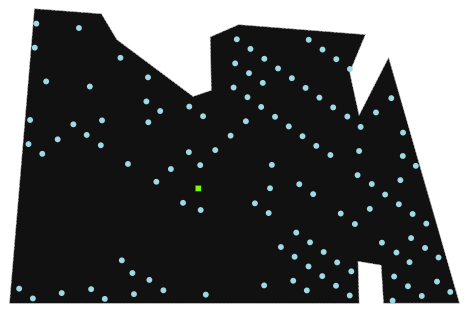

In [5]:
wfn.plot_location()

### Optimize Moray East

Initial heuristic solution to warm-start the solver:

In [6]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_EW = Heuristic(solver='Esau_Williams', model_options=model_options)
res_EW= wfn.optimize(router=router_EW)


<Axes: >

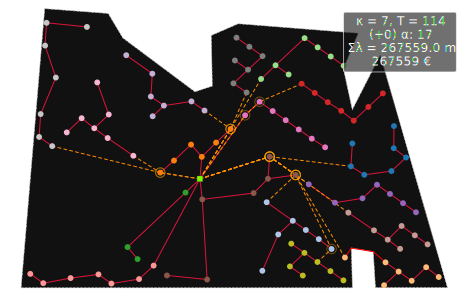

In [7]:
wfn.plot()

In [8]:
model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_EW = Heuristic(solver='Esau_Williams', model_options=model_options)
res_EW= wfn.optimize(router=router_EW)

<Axes: >

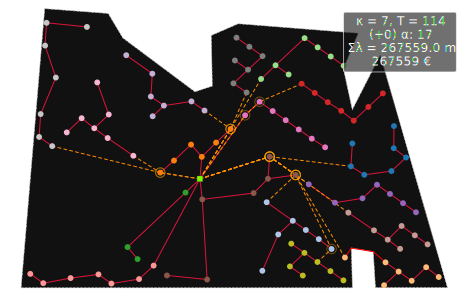

In [9]:
wfn.plot()

In [10]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=0.5, model_options=model_options)
res_EW= wfn.optimize(router=router_hgs) 

In [11]:
print(wfn.S.graph['solution_time'])

0.32


<Axes: >

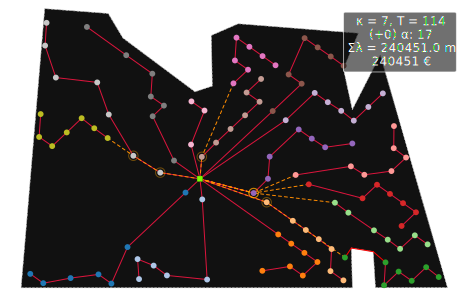

In [12]:
wfn.plot()

In [13]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router_milp1 = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp1)

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...
>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 15 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 8

Initi

>If desired, set the logging level to `INFO` **before running `.optimize()` with the MILP router** to display detailed messages about the solver configuration and warm-start behavior:
>```python
>import logging
>logging.basicConfig(level=logging.INFO)
>```

<Axes: >

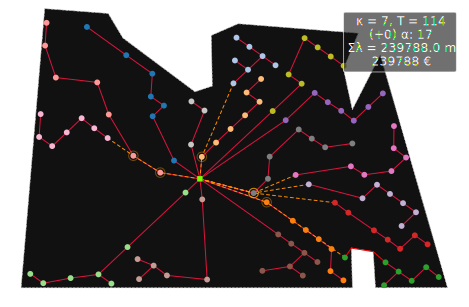

In [14]:
wfn.plot()

In [15]:
ModelOptions.help()

topology in {"radial", "branched", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3", "unlimited"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



In [21]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='straight',
                    )

router_milp2 = MILP(solver_name='cplex', time_limit=15, mip_gap=0.005, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp2)

>>> Using warm start: the model is initialized with the provided solution S <<<
ERROR: Rule failed when generating expression for Constraint cons_feederXedge
with index (0, 93, -1, 7): KeyError: "Index '(-1, 7)' is not valid for indexed
component 'link_'"
ERROR: Constructing component 'cons_feederXedge' from data=None failed:
        KeyError: "Index '(-1, 7)' is not valid for indexed component 'link_'"


KeyError: "Index '(-1, 7)' is not valid for indexed component 'link_'"

In [ ]:
dir(router_milp2.solver)


In [26]:
router_milp2.solver.options

{'parallel': -1, 'emphasis_mip': 4}

In [27]:
router_milp2.optiwindnet_default_options

{'parallel': -1, 'emphasis_mip': 4}

<Axes: >

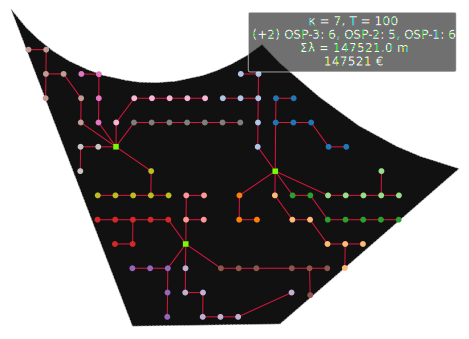

In [ ]:
wfn.plot()

In [ ]:
solver_options=dict(
    num_workers = 8,
)

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router_milp = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)

res = wfn.optimize(router=router_milp)

>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 15 log_search_progress: true relative_gap_limit: 0.01 num_workers: 8

Initial optimization model '': (model_fingerprint: 0x1edfdd6ca6f50e5e)
#Variables: 2'440 (#bools: 1'220 in floating point objective)
  - 1'220 Booleans in [0,1]
  - 920 in [0,6]
  - 300 in [0,7]
#kAtMostOne: 784 (#literals: 2'340)
#kLinear1: 2'440 (#enforced: 2'440)
#kLinearN: 303 (#terms: 6'100)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 1220 terms with magnitude in [1119.02, 18596.1] average = 3976.33
[Scaling] Objective coefficient relative error: 2.09617e-10
[Scaling] Objective worst-case absolute error: 7.84164e-05
[Scaling] Objective scaling factor: 2.09715e+06
  1.12e-03s  0.00e+00d  [DetectDominanceRelations] 
  2.55e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoi